<img src="https://www.pola.rs/share.jpg" width=400 height=200></img>

In [1]:
# !pip install polars altair great-tables colorzero

In [2]:
import polars as pl
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# On the history of `DataFrame`

<img src="./df_hist.png" width=1000 height=500></img>

# Why the name "Polars"?

<font size=5>Because Pandas started it!</font>

<font size=5>Pandas: **Pan**el **Da**ta</font>

<font size=5>Polars: still an ursine, but with the `rs` suffix</font>

# Who?

https://www.ritchievink.com/

# Why?

### 1. Based on the Rust programming language, which is a very interesting language to know, might be very relevant for DS one day. polars has a python and a rust api.
### 2. FAST!
### 3. Can operate on datasets beyond the RAM size
### 4. Come for speed, stay for the API.

# A few words on Rust 

1. C/C++ performance 
2. Memory safety
3. Out of the box parallelism and concurrency
4. Data processing and ML: 
    - [Linfa](https://github.com/rust-ml/linfa) - scikit equivalent
    - [Burn](https://github.com/tracel-ai/burn) - DL package
    - [Polars](https://github.com/pola-rs/polars) - pandas equivalent
    
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Rust_programming_language_black_logo.svg/2048px-Rust_programming_language_black_logo.svg.png" width=50 height=50></img>

<br>
<br>
<br>
<br>
 

## What we will cover:

- Benefits of polars, namely speed
- API differences from Pandas
- Eager API
- Lazy API
- SQL API (Yes, you can use polars directly with SQL)


# The main claim to fame: _speed_

[Link1](https://duckdblabs.github.io/db-benchmark/), [Link2](https://pola.rs/posts/benchmarks/)

## `polars` uses apache's Arrow internally which allows for optimized columnar storage

- `numpy`/`pandas` $\rightarrow$ `polars`: slow since a lot of conversion takes place...
- python primitives $\rightarrow$ `polars`: very fast
- binary files, parquet files... $\rightarrow$ `polars`: smart and fast

In [4]:
%time _ = pl.Series([_ for _ in range(50_000_000)])

CPU times: user 1.07 s, sys: 681 ms, total: 1.75 s
Wall time: 1.94 s


In [5]:
# fails on 100M, while polars achieves it in ~6.2 seconds
%time _ = pd.Series([_ for _ in range(50_000_000)])

CPU times: user 4.84 s, sys: 1.24 s, total: 6.08 s
Wall time: 6.42 s


In [6]:
arr = np.random.choice(['A', 'B', 'C'], size=100_000_000)

In [7]:
%time pls = pl.Series(arr)

CPU times: user 14.1 s, sys: 454 ms, total: 14.6 s
Wall time: 14.7 s


In [8]:
%time pds = pd.Series(arr)

CPU times: user 812 ms, sys: 168 ms, total: 980 ms
Wall time: 1 s


In [9]:
%time pls.max()

CPU times: user 517 ms, sys: 322 ms, total: 840 ms
Wall time: 1.05 s


'C'

In [10]:
%time pds.max()

CPU times: user 2.85 s, sys: 99.9 ms, total: 2.95 s
Wall time: 2.98 s


'C'

## How long does it take to load a 5M row data set in Polars vs. Pandas? 

In [11]:
_file_location = './yellow_tripdata_2015-01.csv'

In [12]:
%time df_5m = pl.read_csv(_file_location, n_rows=5_000_000)

CPU times: user 1.81 s, sys: 389 ms, total: 2.19 s
Wall time: 1.59 s


In [13]:
%time pd_df = pd.read_csv(_file_location, nrows=5_000_000)

CPU times: user 4.93 s, sys: 1.2 s, total: 6.13 s
Wall time: 6.57 s


#### The full dataset contains 12,748,986 rows and 19 columns

#### Reading the full dataset with pandas will kill the kernel...

#### On polars, however...

In [14]:
%time df = pl.read_csv(_file_location)

CPU times: user 5.13 s, sys: 862 ms, total: 5.99 s
Wall time: 2.93 s


#### Forcing it to use the arrow parser is even shorter

In [15]:
%time df = pl.read_csv(_file_location, use_pyarrow=True)

CPU times: user 9.44 s, sys: 3.12 s, total: 12.6 s
Wall time: 2.07 s


In [16]:
type(df)

polars.dataframe.frame.DataFrame

In [17]:
df.shape

(12748986, 19)

## polars DataFrames have `Schema`s

[`Schemas`](https://docs.pola.rs/api/python/dev/reference/dataframe/api/polars.DataFrame.schema.html) operate like `dict` with keys that are the column names and types that are part of `polars` magic.

Some key methods are:
- `names()` can also be accessed via `df.columns`
- `dtypes()`
- `values()`
- `items()`
- `keys()`
- `to_python()`- will return a `dict`

In [18]:
df.schema

Schema([('VendorID', Int64),
        ('tpep_pickup_datetime', Datetime(time_unit='ms', time_zone=None)),
        ('tpep_dropoff_datetime', Datetime(time_unit='ms', time_zone=None)),
        ('passenger_count', Int64),
        ('trip_distance', Float64),
        ('pickup_longitude', Float64),
        ('pickup_latitude', Float64),
        ('RateCodeID', Int64),
        ('store_and_fwd_flag', String),
        ('dropoff_longitude', Float64),
        ('dropoff_latitude', Float64),
        ('payment_type', Int64),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
        ('tolls_amount', Float64),
        ('improvement_surcharge', Float64),
        ('total_amount', Float64)])

In [19]:
df.columns # is equivalent to df.schema.names()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'RateCodeID',
 'store_and_fwd_flag',
 'dropoff_longitude',
 'dropoff_latitude',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount']

In [20]:
df.estimated_size('gb')

1.7216464607045054

## Dtypes

### `polars` uses columnar storage, since logically, every column has 1 type, having a declared type for each column allows for storing and treating each column separately and in an optimized way

In [21]:
df.schema['VendorID']

Int64

In [22]:
dt = df.schema['VendorID']

In [23]:
type(type(dt))

polars.datatypes.classes.DataTypeClass

In [24]:
dt.min(), dt.max()

(<Expr ['-9223372036854775808'] at 0x431D56610>,
 <Expr ['9223372036854775807'] at 0x12D702CD0>)

In [25]:
dt.is_numeric()

True

In [26]:
dt.is_decimal()

False

In [27]:
dt.is_(df.schema['passenger_count'])

True

### dtypes can help us optimize

In [28]:
df['store_and_fwd_flag'].unique()

store_and_fwd_flag
str
"""Y"""
"""N"""


In [29]:
_c = df['store_and_fwd_flag'].cast(pl.Categorical()) # special data type for low cardinality

In [30]:
%time df['store_and_fwd_flag'].value_counts()

CPU times: user 134 ms, sys: 75.5 ms, total: 209 ms
Wall time: 217 ms


store_and_fwd_flag,count
str,u32
"""Y""",115033
"""N""",12633953


In [31]:
%time _c.value_counts()

CPU times: user 30.1 ms, sys: 12.2 ms, total: 42.3 ms
Wall time: 41.7 ms


store_and_fwd_flag,count
cat,u32
"""N""",12633953
"""Y""",115033


# Eager Execution using `polars`

## Basic DataFrame methods

### Creating DataFrames ad hoc

In [32]:
pl.DataFrame({'a': [1,2,3,4], 'b': [4,5,6,7]})

a,b
i64,i64
1,4
2,5
3,6
4,7


In [33]:
# Our NYC dataset

df.head()

# Note that strings are quoted "some str"

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
i64,datetime[ms],datetime[ms],i64,f64,f64,f64,i64,str,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,"""N""",-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.3,-74.001648,40.724243,1,"""N""",-73.994415,40.759109,1,14.5,0.5,0.5,2.0,0.0,0.3,17.8
1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.8,-73.963341,40.802788,1,"""N""",-73.95182,40.824413,2,9.5,0.5,0.5,0.0,0.0,0.3,10.8
1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.5,-74.009087,40.713818,1,"""N""",-74.004326,40.719986,2,3.5,0.5,0.5,0.0,0.0,0.3,4.8
1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.0,-73.971176,40.762428,1,"""N""",-74.004181,40.742653,2,15.0,0.5,0.5,0.0,0.0,0.3,16.3


## Some attributes

In [34]:
df.height  # how many rows

12748986

In [35]:
df.width  # how many columns

19

In [36]:
df.flags  # holds the information if a column is sorted or not to avoid repeat sorting

{'VendorID': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'tpep_pickup_datetime': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'tpep_dropoff_datetime': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'passenger_count': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'trip_distance': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'pickup_longitude': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'pickup_latitude': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'RateCodeID': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'store_and_fwd_flag': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'dropoff_longitude': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'dropoff_latitude': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'payment_type': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'fare_amount': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'extra': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'mta_tax': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'tip_amount': {'SORTED_ASC': False, 'SORTED_D

### The `describe()` method

In [37]:
%time df_5m.describe()

CPU times: user 955 ms, sys: 687 ms, total: 1.64 s
Wall time: 285 ms


statistic,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
str,f64,str,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",5e6,"""5000000""","""5000000""",5e6,5e6,5e6,5e6,5e6,"""5000000""",5e6,5e6,5e6,5e6,5e6,5e6,5e6,5e6,5e6,5e6
"""null_count""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.5199624,null,null,1.679231,8.050024,-72.557148,39.970157,1.0365444,null,-72.604608,39.997219,1.3866874,11.903924,0.310775,0.4978076,1.545083,0.24298,0.283626,14.799807
"""std""",0.499601,null,null,1.33552,6473.289552,10.141781,5.586894,0.647231,null,9.982288,5.496567,0.49878,10.308317,0.753201,0.035267,2.417063,1.534495,0.068147,12.571749
"""min""",1.0,"""2015-01-01 00:03:48""","""2015-01-01 00:04:12""",0.0,0.0,-121.925812,0.0,1.0,"""N""",-736.416687,-9.029157,1.0,-450.0,-2.0,-0.5,-81.0,-11.75,0.0,-450.3
"""25%""",1.0,null,null,1.0,1.0,-73.991684,40.735516,1.0,null,-73.991196,40.734352,1.0,6.5,0.0,0.5,0.0,0.0,0.3,8.19
"""50%""",2.0,null,null,1.0,1.67,-73.981606,40.753151,1.0,null,-73.979759,40.753616,1.0,9.0,0.0,0.5,1.0,0.0,0.3,11.16
"""75%""",2.0,null,null,2.0,3.0,-73.966667,40.767555,1.0,null,-73.96244,40.768833,2.0,13.5,0.5,0.5,2.06,0.0,0.3,16.3
"""max""",2.0,"""2015-01-31 23:59:59""","""2016-02-02 13:51:38""",9.0,1.1800e7,78.662651,53.784027,99.0,"""Y""",85.274025,404.833344,5.0,3005.5,999.99,0.5,750.0,1000.66,0.3,3006.35


In [38]:
%time pd_df.describe()

CPU times: user 1.36 s, sys: 429 ms, total: 1.78 s
Wall time: 2.03 s


,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,1.519962e+00,1.679231e+00,8.050024e+00,-7.255715e+01,3.997016e+01,1.036544e+00,-7.260461e+01,3.999722e+01,1.386687e+00,1.190392e+01,3.107748e-01,4.978076e-01,1.545083e+00,2.429798e-01,2.836262e-01,1.479981e+01
std,4.996014e-01,1.335520e+00,6.473290e+03,1.014178e+01,5.586894e+00,6.472306e-01,9.982288e+00,5.496567e+00,4.987796e-01,1.030832e+01,7.532012e-01,3.526746e-02,2.417063e+00,1.534495e+00,6.814711e-02,1.257175e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,-1.219258e+02,0.000000e+00,1.000000e+00,-7.364167e+02,-9.029157e+00,1.000000e+00,-4.500000e+02,-2.000000e+00,-5.000000e-01,-8.100000e+01,-1.175000e+01,0.000000e+00,-4.503000e+02
25%,1.000000e+00,1.000000e+00,1.000000e+00,-7.399168e+01,4.073552e+01,1.000000e+00,-7.399120e+01,4.073435e+01,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.190000e+00
50%,2.000000e+00,1.000000e+00,1.670000e+00,-7.398161e+01,4.075315e+01,1.000000e+00,-7.397976e+01,4.075362e+01,1.000000e+00,9.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,3.000000e-01,1.116000e+01
75%,2.000000e+00,2.000000e+00,3.000000e+00,-7.396667e+01,4.076756e+01,1.000000e+00,-7.396244e+01,4.076883e+01,2.000000e+00,1.350000e+01,5.000000e-01,5.000000e-01,2.060000e+00,0.000000e+00,3.000000e-01,1.630000e+01
max,2.000000e+00,9.000000e+00,1.180000e+07,7.866265e+01,5.378403e+01,9.900000e+01,8.527402e+01,4.048333e+02,5.000000e+00,3.005500e+03,9.999900e+02,5.000000e-01,7.500000e+02,1.000660e+03,3.000000e-01,3.006350e+03


## Indexing: No `index` attribute, no `loc`/`iloc` methods... 
instead one canjust refer to row number (0 based indexing)

In [39]:
df[0,0]

2

In [40]:
df['VendorID']

VendorID
i64
2
1
1
1
1
…
1
1
1


In [41]:
df[0,'VendorID']

2

In [42]:
df[1000:1004,['tpep_dropoff_datetime', 'pickup_longitude']]

tpep_dropoff_datetime,pickup_longitude
datetime[ms],f64
2015-01-07 20:45:40,-73.995155
2015-01-07 20:43:41,-73.960281
2015-01-07 20:53:31,-73.967667
2015-01-07 21:02:08,-73.986908


In [43]:
type(df[0,:])

polars.dataframe.frame.DataFrame

In [44]:
type(df[:,0])

polars.series.series.Series

## A common `pandas` pattern is to use masks for filtering...

```python
df = pd.read_csv('/somewhere/something.csv')

mask = df['age'] > 30

df = df[mask] # would filter the DataFrame

```

## ... but it's not supported in `polars` ...

In [45]:
mask = df['VendorID'] == 1

In [46]:
df[mask, 'passenger_count'] # this should fail

TypeError: selecting rows by passing a boolean mask to `__getitem__` is not supported

Hint: Use the `filter` method instead.

## ... we'll get to `filter` later

## Other indexing methods `rows`/`iter_rows`/`rows_by_key`

In [47]:
df_ex = pl.DataFrame(
     {
         "x": ["a", "b", "b", "a"],
         "y": [1, 2, 3, 4],
         "z": [0, 3, 6, 9],
     }
)

df_ex

x,y,z
str,i64,i64
"""a""",1,0
"""b""",2,3
"""b""",3,6
"""a""",4,9


### <font color='red'>Materialization Warning:</font> Use with caution: `rows`

Unlike `pandas`, `polars` does not store the values of the dataframe directly in memory, there is some disk usage that takes place and also the serialization is columnar, so when we call `rows()` it means that:<br>
1 - we materialize the entire dataframe<br>
2 - we circulate through each row and each column resulting in $O(N\times C)$ complexity<br>

In [48]:
df_ex.rows() # a very expensive operation

[('a', 1, 0), ('b', 2, 3), ('b', 3, 6), ('a', 4, 9)]

In [49]:
df_ex.rows(named=True) # or use df_ex.to_dicts()

[{'x': 'a', 'y': 1, 'z': 0},
 {'x': 'b', 'y': 2, 'z': 3},
 {'x': 'b', 'y': 3, 'z': 6},
 {'x': 'a', 'y': 4, 'z': 9}]

### Memory effective option is using iterators: `iter_rows`

In [50]:
for row in df_ex.iter_rows():
    print(row)

('a', 1, 0)
('b', 2, 3)
('b', 3, 6)
('a', 4, 9)


In [51]:
_sum = 0
for row in df_ex.iter_rows():
    _sum += row[1]
    
print(f"the sum of the 2nd column is {_sum}")

the sum of the 2nd column is 10


In [52]:
# value of last column in each row as a list
[row[-1] for row in df_ex.iter_rows()]

[0, 3, 6, 9]

In [53]:
# value of named in each row as a list
[row['x'] for row in df_ex.iter_rows(named=True)]

['a', 'b', 'b', 'a']

### <font color='red'>Materialization Warning:</font> `rows_by_key`

In [54]:
df_ex

x,y,z
str,i64,i64
"""a""",1,0
"""b""",2,3
"""b""",3,6
"""a""",4,9


In [55]:
df_ex.rows_by_key(key=['x'])

defaultdict(list, {'a': [(1, 0), (4, 9)], 'b': [(2, 3), (3, 6)]})

In [56]:
df_ex.rows_by_key(key=['x'], named=True)

defaultdict(list,
            {'a': [{'y': 1, 'z': 0}, {'y': 4, 'z': 9}],
             'b': [{'y': 2, 'z': 3}, {'y': 3, 'z': 6}]})

###  Unsure? Confused? You can always go back `to_pandas` or `to_numpy` 

In [57]:
df_ex.to_pandas()

,x,y,z
0,a,1,0
1,b,2,3
2,b,3,6
3,a,4,9


In [59]:
df_ex.to_numpy()

array([['a', 1, 0],
       ['b', 2, 3],
       ['b', 3, 6],
       ['a', 4, 9]], dtype=object)

## Expressions

### (The diagram is my own)

<img src="./api_layers.png" height=1200 width=400></img>

In [60]:
c1 = pl.col("VendorID")

In [61]:
c1

<Expr ['col("VendorID")'] at 0x50256FB90>

In [62]:
type(c1)

polars.expr.expr.Expr

In [63]:
df.select(c1).head(3)

VendorID
i64
2
1
1


In [64]:
df.select(pl.col("VendorID", "pickup_longitude"))

VendorID,pickup_longitude
i64,f64
2,-73.993896
1,-74.001648
1,-73.963341
1,-74.009087
1,-73.971176
…,…
1,-73.951988
1,-73.982742
1,-73.979324


In [65]:
df.select("VendorID", "pickup_longitude")

VendorID,pickup_longitude
i64,f64
2,-73.993896
1,-74.001648
1,-73.963341
1,-74.009087
1,-73.971176
…,…
1,-73.951988
1,-73.982742
1,-73.979324


### Filtering using expressions

In [66]:
mask = pl.col("pickup_longitude") > -73.

In [67]:
mask # Not materialized, just the instruction

<Expr ['[(col("pickup_longitude")) > (…'] at 0x5026172D0>

In [68]:
type(mask)

polars.expr.expr.Expr

In [69]:
type((pl.col("pickup_longitude") > -73.) & (pl.col("passenger_count") < 1))

polars.expr.expr.Expr

In [70]:
df.filter(
    (pl.col("pickup_longitude") > -73.) & 
    (pl.col("passenger_count") < 1)
)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
i64,datetime[ms],datetime[ms],i64,f64,f64,f64,i64,str,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
1,2015-01-14 09:59:32,2015-01-14 10:03:36,0,0.7,0.0,0.0,1,"""N""",-73.989235,40.769493,2,5.0,0.0,0.5,0.0,0.0,0.3,5.8
1,2015-01-15 22:51:35,2015-01-15 23:10:11,0,5.6,0.0,0.0,1,"""N""",-73.923241,40.743538,1,19.0,0.5,0.5,4.05,0.0,0.3,24.35
1,2015-01-01 02:52:01,2015-01-01 03:15:09,0,4.2,0.0,0.0,1,"""N""",-73.952553,40.7141,1,18.0,0.5,0.5,3.85,0.0,0.0,23.15
1,2015-01-31 00:39:09,2015-01-31 00:48:51,0,1.5,0.0,0.0,1,"""N""",-73.981911,40.736889,1,8.0,0.5,0.5,1.85,0.0,0.3,11.15
1,2015-01-24 20:07:52,2015-01-24 20:10:52,0,0.5,0.0,0.0,1,"""N""",-73.97126,40.758507,1,4.0,0.5,0.5,1.55,0.0,0.3,6.85
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,2015-01-16 21:26:44,2015-01-16 21:39:23,0,3.0,0.0,0.0,1,"""N""",-73.970886,40.693371,1,12.0,0.5,0.5,3.3,0.0,0.3,16.6
1,2015-01-11 11:31:09,2015-01-11 11:38:52,0,1.5,0.0,0.0,1,"""N""",0.0,0.0,2,7.5,0.0,0.5,0.0,0.0,0.3,8.3
1,2015-01-18 01:47:30,2015-01-18 01:55:03,0,1.4,0.0,0.0,1,"""N""",-74.004585,40.742241,1,7.0,0.5,0.5,0.11,0.0,0.3,8.41


### Adding columns - the wrong way (another common `pandas` pattern)

In [71]:
df['x'] = 1 # this should fail

TypeError: DataFrame object does not support `Series` assignment by index

Use `DataFrame.with_columns`.

### Adding columns - the right way

In [72]:
df = df.with_columns(pl.Series('x', [1]*df.shape[0]))

In [73]:
df.select('x').head()

x
i64
1
1
1
1
1


### Using literals: a safer way to work with constants as expressions

In [74]:
_lit = pl.lit(1)
_lit

<Expr ['dyn int: 1'] at 0x502613D90>

In [75]:
type(_lit)

polars.expr.expr.Expr

In [76]:
df = df.with_columns(pl.lit(2).alias('y'))

In [77]:
df.select('y', 'x', 'VendorID').head()

y,x,VendorID
i32,i64,i64
2,1,2
2,1,1
2,1,1
2,1,1
2,1,1


### Using expressions to add columns

In [78]:
df_ex

x,y,z
str,i64,i64
"""a""",1,0
"""b""",2,3
"""b""",3,6
"""a""",4,9


In [79]:
df_ex.select(pl.col('x'), pl.col('y')+1)

x,y
str,i64
"""a""",2
"""b""",3
"""b""",4
"""a""",5


In [80]:
df_ex.select( 
    
    (pl.col('y')/2).alias('y/2'),
    
    (2/pl.col('y')).alias('2/y'),
    
    (pl.col('y') + pl.col('z')).alias('y+z'),
    
    pl.col('z').arctan().alias('arctan(z)'),
    
    pl.col('z').arctan().ceil().alias('ceil(arctan(z))'),
    
    (pl.col('z')-5).abs().alias('abs(z-5)'),
    
    pl.col('z').is_in([1,2,3]).alias('z is in (1,2,3)'),
    
    pl.col('z').pow(2).alias('z**2'),
    
    (pl.col('y')**2).alias('y**2')
    
)

y/2,2/y,y+z,arctan(z),ceil(arctan(z)),abs(z-5),"z is in (1,2,3)",z**2,y**2
f64,f64,i64,f64,f64,i64,bool,i64,i64
0.5,2.0,1,0.0,0.0,5,false,0,1
1.0,1.0,5,1.249046,2.0,2,true,9,4
1.5,0.666667,9,1.405648,2.0,1,false,36,9
2.0,0.5,13,1.460139,2.0,4,false,81,16


### Casting types

In [81]:
df.select(pl.col('VendorID').cast(pl.String))

VendorID
str
"""2"""
"""1"""
"""1"""
"""1"""
"""1"""
…
"""1"""
"""1"""
"""1"""


### But I really like my python function...

In [82]:
def plus_2(x):
    return x+2

In [83]:
df.select(
    original=pl.col('VendorID'), 
    plus_2=pl.col('VendorID').pipe(plus_2)
)

original,plus_2
i64,i64
2,4
1,3
1,3
1,3
1,3
…,…
1,3
1,3
1,3


### Case when..

In [84]:
# add a month_name column
df = df.with_columns(
    (pl.col("tpep_pickup_datetime").dt.strftime("%b").alias("month_name")),
    (pl.col("tpep_pickup_datetime").dt.strftime("%d").alias("month_day").cast(pl.Int64)),
)

In [85]:
df.select('tpep_pickup_datetime', 'month_name', 'month_day')

tpep_pickup_datetime,month_name,month_day
datetime[ms],str,i64
2015-01-15 19:05:39,"""Jan""",15
2015-01-10 20:33:38,"""Jan""",10
2015-01-10 20:33:38,"""Jan""",10
2015-01-10 20:33:39,"""Jan""",10
2015-01-10 20:33:39,"""Jan""",10
…,…,…
2015-01-10 19:01:44,"""Jan""",10
2015-01-10 19:01:44,"""Jan""",10
2015-01-10 19:01:44,"""Jan""",10


In [86]:
my_col = (
    pl.when(pl.col('month_day') <= 10)
      .then(pl.lit('first 10 days'))
      .when(pl.col('month_day') <= 20)
      .then(pl.lit('middle 10 days'))
      .otherwise(pl.lit('last 10 days'))
)

In [87]:
type(my_col)

polars.expr.expr.Expr

In [88]:
df = df.with_columns(my_col.alias('day_group'))

In [89]:
df.select('tpep_pickup_datetime', 'day_group')

tpep_pickup_datetime,day_group
datetime[ms],str
2015-01-15 19:05:39,"""middle 10 days"""
2015-01-10 20:33:38,"""first 10 days"""
2015-01-10 20:33:38,"""first 10 days"""
2015-01-10 20:33:39,"""first 10 days"""
2015-01-10 20:33:39,"""first 10 days"""
…,…
2015-01-10 19:01:44,"""first 10 days"""
2015-01-10 19:01:44,"""first 10 days"""
2015-01-10 19:01:44,"""first 10 days"""


### Removing columns

In [90]:
df = df.drop('x') # or an iterator or a pointer to a pl.col

## Group by

<font color='red'>A note on api method names:</font> words will always be separated by an underscore `group_by`, `value_counts` etc...

### agg expressions

In [91]:
pl.col('passenger_count').sum()

<Expr ['col("passenger_count").sum()'] at 0x12EC08310>

In [92]:
type(pl.col('passenger_count').sum())

polars.expr.expr.Expr

In [93]:
df.group_by('month_name', 'day_group').agg(
    pl.len().alias('trips'), # count(1) like SQL
    pl.col('passenger_count').sum().alias('passengers'),
    pl.col('trip_distance').sum().alias('distance_driven'),
)

month_name,day_group,trips,passengers,distance_driven
str,str,u32,i64,f64
"""Jan""","""first 10 days""",4054765,6911863,6.7455e7
"""Jan""","""middle 10 days""",4288724,7171697,4.0116e7
"""Jan""","""last 10 days""",4405497,7353743,6.4019e7


### `group_by_dynamic`

In [94]:
result = (
    df.filter(pl.col('month_day') <= 3)
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(
            pl.len().alias('trips'),
            pl.col('passenger_count').sum().alias('passengers'),
            pl.col('trip_distance').sum().alias('distance_driven')
        )
)
result

tpep_pickup_datetime,trips,passengers,distance_driven
datetime[ms],u32,i64,f64
2015-01-01 00:00:00,28312,51700,82489.09
2015-01-01 01:00:00,31707,58584,99258.12
2015-01-01 02:00:00,28068,51507,91865.7
2015-01-01 03:00:00,24288,44134,84036.57
2015-01-01 04:00:00,17081,30799,63055.28
…,…,…,…
2015-01-03 19:00:00,25667,46194,3240988.5
2015-01-03 20:00:00,20531,36959,54915.04
2015-01-03 21:00:00,21399,38224,56920.38


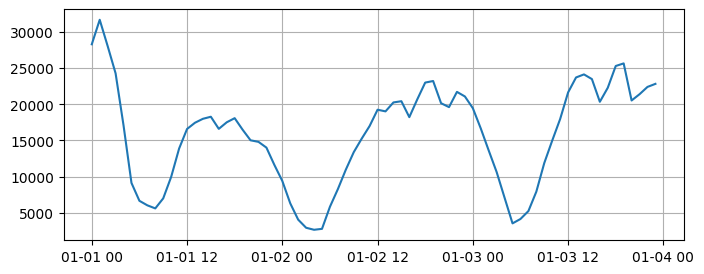

In [95]:
plt.figure(figsize=(8,3))
plt.plot(result['tpep_pickup_datetime'], result['trips'])
plt.grid()
plt.show()

<font color='red'>Note:</font>`polars` supports built-in plotting methods like `pandas`, but not using matplotlib. It uses `altair` instead, which works on `pandas` natively, not sure why this package was chosen for integration...

In [96]:
result.plot.line(x='tpep_pickup_datetime', y='trips').properties(
    width=600,
    height=200
)

alt.Chart(...)

### SQL-like analytic functions are also available

In [97]:
window = {
    'partition_by': [None],
    'order_by': ['tpep_pickup_datetime']
}

result = (
    df.filter(pl.col('month_day') == 1)
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(pl.len().alias('trips'))
        .with_columns(pl.col('trips').cum_sum()
                      .over(**window)
                      .alias('cumulative_trips'))
        .with_columns((pl.col('cumulative_trips') / pl.col('trips').sum().over([None])).alias('F'))
        .rename({'tpep_pickup_datetime':'hour'})
)
result

hour,trips,cumulative_trips,F
datetime[ms],u32,u32,f64
2015-01-01 00:00:00,28312,28312,0.074112
2015-01-01 01:00:00,31707,60019,0.157112
2015-01-01 02:00:00,28068,88087,0.230586
2015-01-01 03:00:00,24288,112375,0.294165
2015-01-01 04:00:00,17081,129456,0.338878
…,…,…,…
2015-01-01 19:00:00,16485,326581,0.854893
2015-01-01 20:00:00,15017,341598,0.894203
2015-01-01 21:00:00,14801,356399,0.932947


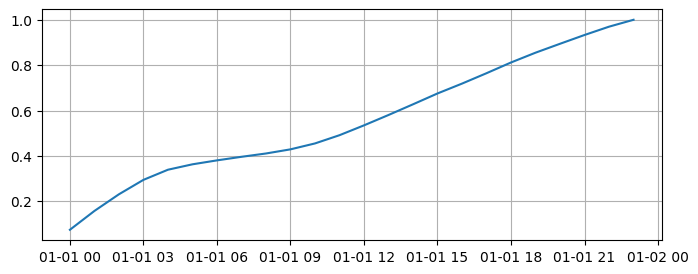

In [98]:
_, ax = plt.subplots(figsize=(8,3))
ax.plot(result['hour'], result['F'])
ax.grid()

plt.show()

### Joins

In [99]:
result1 = (
    df.filter(pl.col('month_day') == 1)
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(pl.len().alias('trips'))
        .with_columns(pl.col('tpep_pickup_datetime').dt.strftime('%H').alias('hour'))
)

result2 = (
    df.filter(pl.col('month_day') == 2)
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(pl.len().alias('trips'))
        .with_columns(pl.col('tpep_pickup_datetime').dt.strftime('%H').alias('hour'))
)

result1.join(result2, on='hour')

tpep_pickup_datetime,trips,hour,tpep_pickup_datetime_right,trips_right
datetime[ms],u32,str,datetime[ms],u32
2015-01-01 00:00:00,28312,"""00""",2015-01-02 00:00:00,9388
2015-01-01 01:00:00,31707,"""01""",2015-01-02 01:00:00,6291
2015-01-01 02:00:00,28068,"""02""",2015-01-02 02:00:00,4027
2015-01-01 03:00:00,24288,"""03""",2015-01-02 03:00:00,2905
2015-01-01 04:00:00,17081,"""04""",2015-01-02 04:00:00,2626
…,…,…,…,…
2015-01-01 19:00:00,16485,"""19""",2015-01-02 19:00:00,23227
2015-01-01 20:00:00,15017,"""20""",2015-01-02 20:00:00,20153
2015-01-01 21:00:00,14801,"""21""",2015-01-02 21:00:00,19611


# Lazy API

So far we've been showing the 'eager' api, that performs calculations 'as they come'.

The **lazy** api works in a 'tell me what you want to do, and let me do it on my own' fashion

In [100]:
lf = pl.scan_csv(_file_location)
lf

In [101]:
type(lf)

polars.lazyframe.frame.LazyFrame

In [102]:
print(lf.explain())

Csv SCAN [./yellow_tripdata_2015-01.csv]
PROJECT */19 COLUMNS


### What the hell is $\pi */19$?

It's part of **relational algebra** (the math behind SQL), and it means:
- $\pi$ is the projection operator (in this case it just means 'select')
- ... the set of all rows * 
- ... over 19 columns

In [103]:
lf = (
    pl.scan_csv(_file_location)
    .with_columns(pl.col('tpep_pickup_datetime').str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S"))
    .filter(pl.col('VendorID') == 1)
    .sort('tpep_pickup_datetime')
    .group_by_dynamic('tpep_pickup_datetime', every='1h')
    .agg(
        pl.len().alias('trips'),
        pl.col('passenger_count').sum().alias('passengers'),
        pl.col('trip_distance').sum().alias('distance_driven')
    )
)

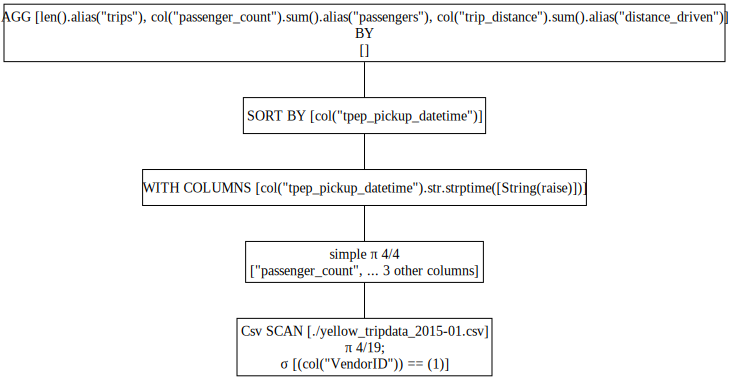

In [104]:
lf.show_graph()

The $\sigma$ operator is another of operation in Relational Algebra that is related to filters.

### What can we know about the LazyFrame without materializing it?

#### <font color='red'>Materialization Warning:</font> calling `columns` will perform materialization

In [105]:
# should warn with PerformanceWarning
%time lf.columns

CPU times: user 439 µs, sys: 441 µs, total: 880 µs
Wall time: 826 µs


<timed eval>:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.


['tpep_pickup_datetime', 'trips', 'passengers', 'distance_driven']

In [106]:
# better to use 'collect_schema'
%time lf.collect_schema()

CPU times: user 85 µs, sys: 34 µs, total: 119 µs
Wall time: 115 µs


Schema([('tpep_pickup_datetime', Datetime(time_unit='us', time_zone=None)),
        ('trips', UInt32),
        ('passengers', Int64),
        ('distance_driven', Float64)])

### But there's no data here, just instructions. So using indices for example, will result in an error

In [107]:
lf[0:1,'trips'] # this should fail

TypeError: 'LazyFrame' object is not subscriptable (aside from slicing)

Use `select()` or `filter()` instead.

### Materialization has to be explicit, using `collect` to get a `polars.DataFrame`

In [108]:
%time lazy_result = lf.collect()

CPU times: user 2.77 s, sys: 1.29 s, total: 4.06 s
Wall time: 4.01 s


In [109]:
def eager_time_test():
    return (
        pl.read_csv(_file_location)
        .with_columns(pl.col('tpep_pickup_datetime').str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S"))
        .filter(pl.col('VendorID') == 1)
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(
            pl.len().alias('trips'),
            pl.col('passenger_count').sum().alias('passengers'),
            pl.col('trip_distance').sum().alias('distance_driven')
        )
    )

In [110]:
%time eager_result = eager_time_test()

CPU times: user 7.91 s, sys: 4.32 s, total: 12.2 s
Wall time: 2.53 s


In [111]:
%time lazy_result = lf.collect() 

CPU times: user 2.72 s, sys: 799 ms, total: 3.52 s
Wall time: 2.67 s


In [112]:
lazy_result.head()

tpep_pickup_datetime,trips,passengers,distance_driven
datetime[μs],u32,i64,f64
2015-01-01 00:00:00,13595,21022,39068.9
2015-01-01 01:00:00,15116,23574,47001.2
2015-01-01 02:00:00,13427,20672,43036.7
2015-01-01 03:00:00,11705,17515,39993.0
2015-01-01 04:00:00,8070,11661,29299.7


In [113]:
eager_result.head()

tpep_pickup_datetime,trips,passengers,distance_driven
datetime[μs],u32,i64,f64
2015-01-01 00:00:00,13595,21022,39068.9
2015-01-01 01:00:00,15116,23574,47001.2
2015-01-01 02:00:00,13427,20672,43036.7
2015-01-01 03:00:00,11705,17515,39993.0
2015-01-01 04:00:00,8070,11661,29299.7


In [114]:
lazy_result.equals(eager_result)

True

### Profiling

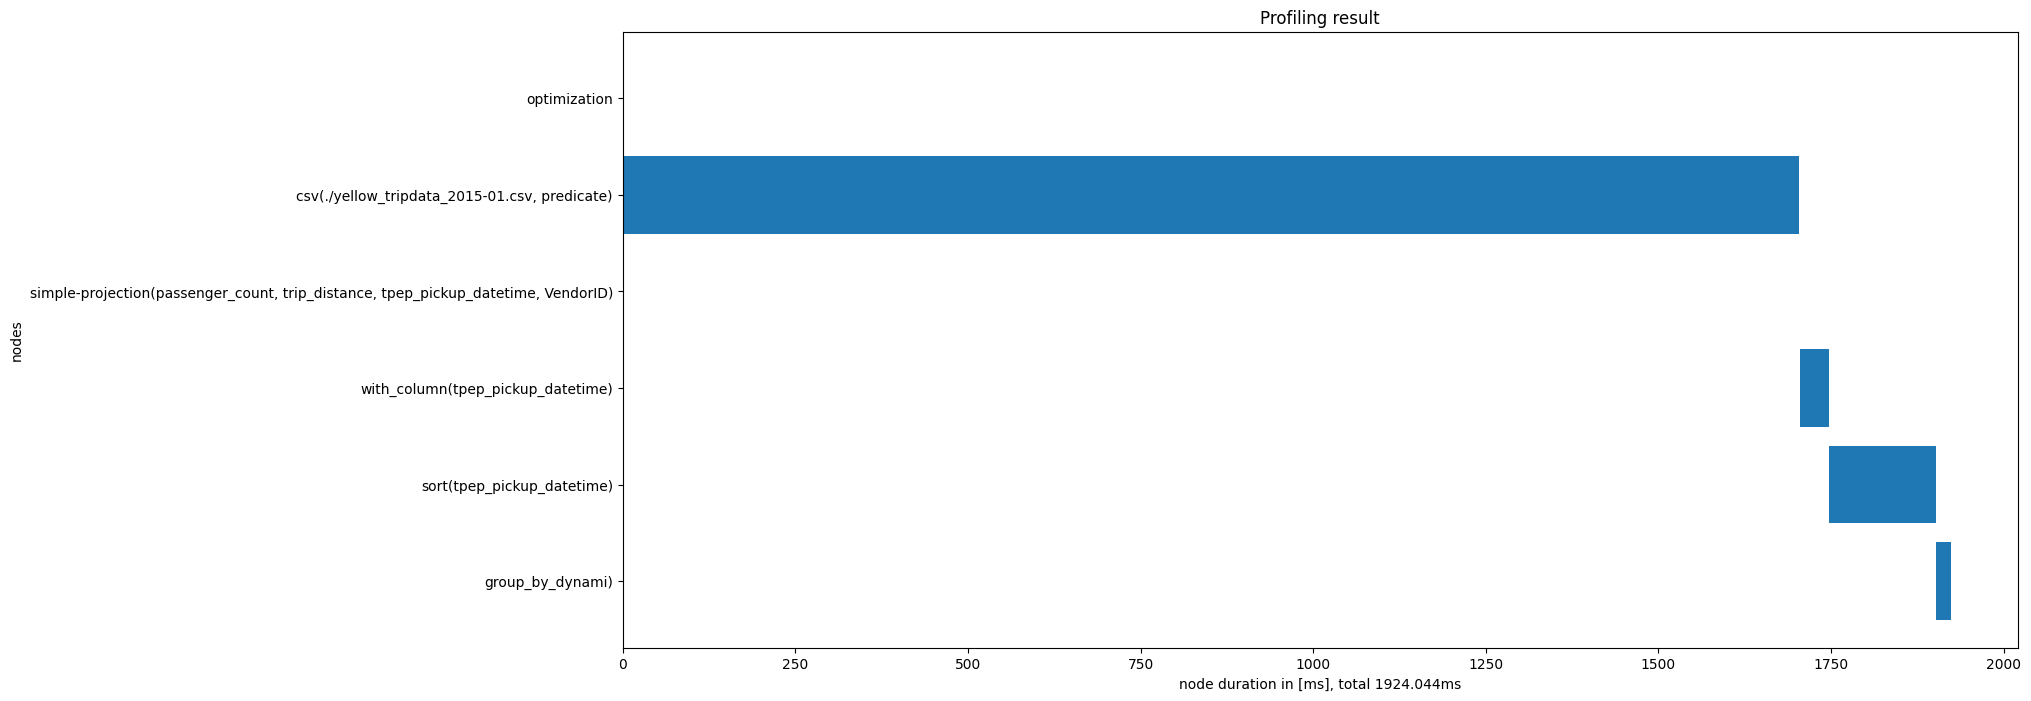

In [115]:
result, profile_result = lf.profile(show_plot=True)

In [116]:
profile_result

node,start,end
str,u64,u64
"""optimization""",0,1116
"""csv(./yellow_tripdata_2015-01.…",1116,1703565
"""simple-projection(passenger_co…",1703770,1704146
"""with_column(tpep_pickup_dateti…",1704872,1746449
"""sort(tpep_pickup_datetime)""",1746679,1902364
"""group_by_dynami)""",1902369,1924044


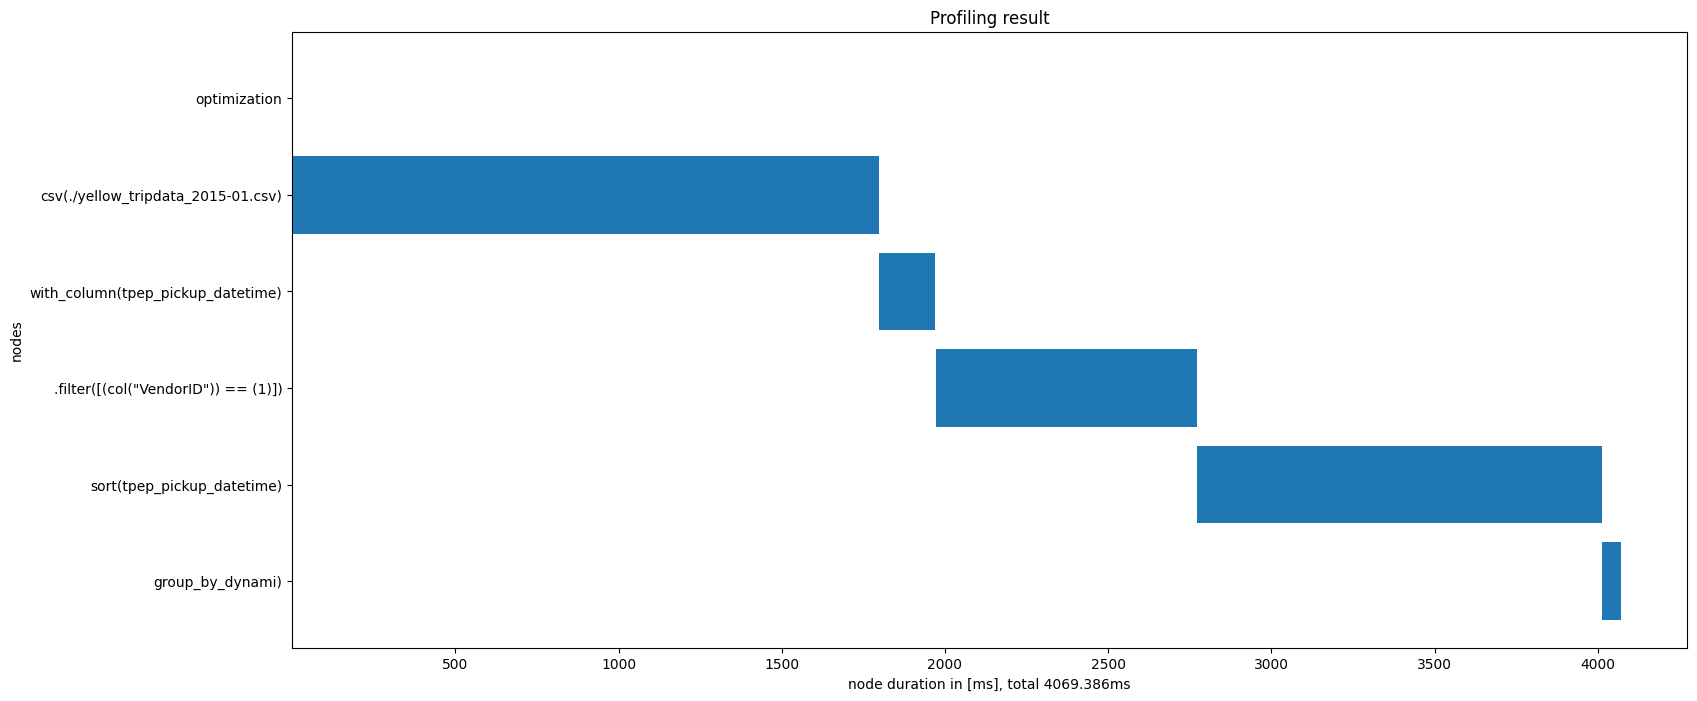

In [117]:
_, profile_result = lf.profile(show_plot=True, predicate_pushdown=False, projection_pushdown=False)

In [118]:
profile_result

node,start,end
str,u64,u64
"""optimization""",0,24
"""csv(./yellow_tripdata_2015-01.…",24,1798925
"""with_column(tpep_pickup_dateti…",1798977,1970340
""".filter([(col(""VendorID"")) == …",1971597,2770937
"""sort(tpep_pickup_datetime)""",2770976,4011058
"""group_by_dynami)""",4011093,4069386


### Directly creating LazyDataFrame

In [119]:
pl.DataFrame({'a': [1,2,3]}).lazy()

## SQL API (Lazy by definition)

<img src="./sql_api.png" width="400" height="400"></img>

In [120]:
result1 = (
    df.filter(pl.col('month_day') == 1)
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(
            pl.len().alias('trips'),
            pl.col('passenger_count').sum().alias('passengers'),
            pl.col('trip_distance').sum().alias('distance_driven')
        )
    .with_columns(pl.col('tpep_pickup_datetime').dt.strftime('%H').alias('hour'))
)


In [121]:
result1

tpep_pickup_datetime,trips,passengers,distance_driven,hour
datetime[ms],u32,i64,f64,str
2015-01-01 00:00:00,28312,51700,82489.09,"""00"""
2015-01-01 01:00:00,31707,58584,99258.12,"""01"""
2015-01-01 02:00:00,28068,51507,91865.7,"""02"""
2015-01-01 03:00:00,24288,44134,84036.57,"""03"""
2015-01-01 04:00:00,17081,30799,63055.28,"""04"""
…,…,…,…,…
2015-01-01 19:00:00,16485,29930,45510.07,"""19"""
2015-01-01 20:00:00,15017,27319,46798.67,"""20"""
2015-01-01 21:00:00,14801,26886,44651.48,"""21"""


In [122]:
pl.sql("""select avg(distance_driven) as avg_distance from result1""")

In [123]:
pl.sql("""select avg(distance_driven) as avg_distance from result1""").collect()

avg_distance
f64
51498.824583


In [124]:
result2 = (
    df.filter(pl.col('month_day') == 3) # <-- 2nd day
        .sort('tpep_pickup_datetime')
        .group_by_dynamic('tpep_pickup_datetime', every='1h')
        .agg(
            pl.len().alias('trips'),
            pl.col('passenger_count').sum().alias('passengers'),
            pl.col('trip_distance').sum().alias('distance_driven')
        )
    .with_columns(pl.col('tpep_pickup_datetime').dt.strftime('%H').alias('hour'))
)

In [125]:
result = pl.sql("""
    select 
        t1.hour, 
        t1.distance_driven as dist1, 
        t2.distance_driven as dist2
    from result1 as t1 join result2 as t2 on t1.hour = t2.hour
    order by 1
""")

mat = result.collect()

In [126]:
mat

hour,dist1,dist2
str,f64,f64
"""00""",82489.09,59056.22
"""01""",99258.12,49830.61
"""02""",91865.7,41690.15
"""03""",84036.57,35877.24
"""04""",63055.28,28130.54
…,…,…
"""19""",45510.07,3240988.5
"""20""",46798.67,54915.04
"""21""",44651.48,56920.38


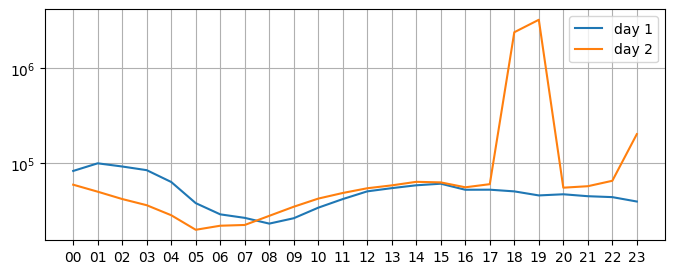

In [127]:
plt.figure(figsize=(8,3))
plt.plot(mat['hour'], mat['dist1'], label='day 1')
plt.plot(mat['hour'], mat['dist2'], label='day 2')
plt.legend()
plt.yscale('symlog')
plt.grid()
plt.show()

## If you don't want to run the entire computation, just to check if you did things correctly

### Use `head(n).collect()`

In [128]:
result.head(2).collect()

hour,dist1,dist2
str,f64,f64
"""00""",82489.09,59056.22
"""01""",99258.12,49830.61


## The SQL API also supports `pandas` DataFrames 

In [129]:
pd_df = pd.DataFrame({'key':[1,2,3], 'a':[0,0,1]})
pl_df = pl.DataFrame({'key':[1,2,3], 'b':[1,0,0]})

pl.sql("""
    select
        pd_df.key,
        pd_df.a,
        pl_df.b,
        greatest(pd_df.a, pl_df.b) as max_ab,
        sum(greatest(pd_df.a, pl_df.b)) over(order by key) as cumsum_max_ab
    from
        pd_df join pl_df on pd_df.key = pl_df.key
""").collect()

key,a,b,max_ab,cumsum_max_ab
i64,i64,i64,i64,i64
1,0,1,1,1
2,0,0,0,1
3,1,0,1,2


## What is supported in SQL?

### The polars team claim they are trying to have everything that PostgreSQL support, but it's still wip

### What's supported right now

- `SELECT`
- `DISTINCT`
- `FROM`
- `JOIN (CROSS JOIN, FULL JOIN, INNER JOIN, [LEFT | RIGHT] [ANTI | SEMI] JOIN`, 
- `WHERE`
- `GROUP BY`
- `HAVING`
- `ORDER BY`
- `LIMIT/OFFSET`
- `EXCEPT`
- `INTERSECT`
- `UNION [ALL]`
- `UNNEST`
- `WITH`
- `OVER`
- Lots and lots of functions...

### Not supported

- `QUALIFY`

## Not covered: SQLContext, other connectors, batch read, caching

You can connect to CSVs, JSON files, Excel, AVRO, Feather, Parquet...

## Working with BigQuery

There is no direct connector to BigQuery, however, BigQuery queries can be transfered in Arrow format

```python
import polars as pl
from google.cloud import bigquery

client = bigquery.Client()

# Perform a query.
QUERY = """
    SELECT a,b,c
    FROM some_table 
    WHERE condition
    LIMIT 100""""

query_job = client.query(QUERY)  
rows = query_job.result() 

df = pl.from_arrow(rows.to_arrow())
```

# Summary:

1. Used correctly, `polars` is superior to `pandas` in terms of performance<br>
2. Not limited to RAM when using lazy execution<br>
2. SQL api, Lazy execution are very handy<br>
3. I personally prefer the functional expression API<br>
4. Multiple connectors are availble (parquet, Excel, CSV, ...)<br>
5. As of Dec 2024 numpy/pandas conversion happens behind the scenes when we fit models and plot stuff, so there is no speed up on scikit-learn/LightGBM/catboost/matplotlib - but, polars is moving quickly and we might see more and more direct integrations<br>
6. Rust - since this is A rapidly growing community, it might have some future for DS/Analytics too, and then polars will be rust's pandas equivalent<br>

## Bonus: `great-tables`

Integrates seamlessly with `polars` you can also use the `selectors` directly when selecting columns.

In [3]:
from great_tables import GT, md, html, nanoplot_options
from colorzero import *

In [4]:
_file_location = './yellow_tripdata_2015-01.csv'
df = pl.read_csv(_file_location)

In [5]:
bw = (
    df
    .sort(pl.col('tpep_pickup_datetime'), descending=False)
    .group_by_dynamic(pl.col('tpep_pickup_datetime').str.to_datetime('%Y-%m-%d %H:%M:%S'), every="1w")
    .agg(
        pl.col('passenger_count').mean().alias('average_passenger_count'),
        pl.col('trip_distance').mean().alias('average_trip_distance'),
        pl.col('fare_amount').mean(),
        pl.col('extra').mean(),
        pl.col('mta_tax').mean(),
        pl.col('tip_amount').mean(),
        pl.col('tolls_amount').mean(),
        pl.col('total_amount').mean())
    ).rename(mapping={'tpep_pickup_datetime':'week'})

bw2 = (
    df
    .sort(pl.col('tpep_pickup_datetime'), descending=False)
    .group_by_dynamic(pl.col('tpep_pickup_datetime').str.to_datetime('%Y-%m-%d %H:%M:%S'), every="1d")
    .agg(pl.col('passenger_count').sum().alias('passenger_count_daily'))
    .rename(mapping={'tpep_pickup_datetime':'day'})
    .sort(pl.col('day'), descending=False)
    .group_by_dynamic(pl.col('day'), every="1w")
    .agg(pl.col('passenger_count_daily').implode())
    .with_columns(pl.col('passenger_count_daily').list.get(0))
    .rename(mapping={'day':'week'})
    )

gt1 = (
    bw.join(bw2, on='week', how='inner').style
        .tab_header('NYC Taxi dataset', subtitle=f"Weekly statistics between Dec 29, 2014 to Jan 26, 2015")
        .tab_stub(rowname_col='week')
        .tab_source_note(source_note='Kaggle, July 2017. https://www.kaggle.com/competitions/nyc-taxi-trip-duration')
        .tab_spanner(label='Averages', columns=['average_passenger_count', 'average_trip_distance'])
        .tab_spanner(label='Avg. Costs', columns=['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount'])
        .fmt_currency(columns=['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount'])
        .fmt_date(columns=['week'], date_style='m_day_year')
        .fmt_number(columns=['average_passenger_count', 'average_trip_distance'], compact=True)
        .fmt_nanoplot(columns='passenger_count_daily', autoscale=True)
        .cols_label(
            average_passenger_count=html('Passenger<br>count'),
            average_trip_distance=html('Trip<br>distance'),
            fare_amount=html('Fare'),
            extra='Extra',
            mta_tax='MTA tax',
            tip_amount='Tip',
            tolls_amount=html('Tolls'),
            total_amount=html('Total'),
            passenger_count_daily=html('Passenger count<br>(daily)')
        )
)
low_col = Color('lime') - Saturation(0.4)
high_col = Color('yellow') - Saturation(0.2)
gt2 = (
    gt1
    .data_color(
        palette=[low_col.html, high_col.html], 
        columns=[k for k,v in bw.schema.items() 
                 if v.is_numeric() 
                 and k not in ('average_passenger_count', 'average_trip_distance')])
    .data_color(
        palette=["white", "blue"], 
        columns=['average_passenger_count', 'average_trip_distance']
    )
)

In [10]:
gt2

GT(_tbl_data=shape: (5, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ week      ┆ average_p ┆ average_t ┆ fare_amou ┆ … ┆ tip_amoun ┆ tolls_amo ┆ total_amo ┆ passenge │
│ ---       ┆ assenger_ ┆ rip_dista ┆ nt        ┆   ┆ t         ┆ unt       ┆ unt       ┆ r_count_ │
│ datetime[ ┆ count     ┆ nce       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ daily    │
│ μs]       ┆ ---       ┆ ---       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆ f64       ┆ f64       ┆           ┆   ┆           ┆           ┆           ┆ list[i64 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ ]        │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2014-12-2 ┆ 1.766969  ┆ 19.393444 ┆ 12.259514 ┆ … ┆ 1.33035   ┆ 0.264227  ┆ 14.909873 ┆ [690407, │
│ 9         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 606716,  │
│ 00:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ …        │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 565709]  │
│ 2015-01-0 ┆ 1.675578  ┆ 22.713874 ┆ 11.767176 ┆ … ┆ 1.512062  ┆ 0.239516  ┆ 14.637098 ┆ [600760, │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 632469,  │
│ 00:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ …        │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 719033]  │
│ 2015-01-1 ┆ 1.671457  ┆ 2.75792   ┆ 11.890466 ┆ … ┆ 2.841937  ┆ 0.248048  ┆ 16.094246 ┆ [648214, │
│ 2         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 734847,  │
│ 00:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ …        │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 743288]  │
│ 2015-01-1 ┆ 1.667416  ┆ 18.76329  ┆ 11.924381 ┆ … ┆ 1.612231  ┆ 0.253735  ┆ 14.886225 ┆ [575507, │
│ 9         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 661009,  │
│ 00:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ …        │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 694420]  │
│ 2015-01-2 ┆ 1.665861  ┆ 4.784368  ┆ 11.855754 ┆ … ┆ 1.592241  ┆ 0.214637  ┆ 14.783954 ┆ [375606, │
│ 6         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 232108,  │
│ 00:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ …        │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 898122]  │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘, _body=<great_tables._gt_data.Body object at 0x11ffcf110>, _boxhead=Boxhead([ColInfo(var='week', type=<ColInfoTypeEnum.stub: 2>, column_label='week', column_align='right', column_width=None), ColInfo(var='average_passenger_count', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Passenger<br>count'), column_align='right', column_width=None), ColInfo(var='average_trip_distance', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Trip<br>distance'), column_align='right', column_width=None), ColInfo(var='fare_amount', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Fare'), column_align='right', column_width=None), ColInfo(var='extra', type=<ColInfoTypeEnum.default: 1>, column_label='Extra', column_align='right', column_width=None), ColInfo(var='mta_tax', type=<ColInfoTypeEnum.default: 1>, column_label='MTA tax', column_align='right', column_width=None), ColInfo(var='tip_amount', type=<ColInfoTypeEnum.default: 1>, column_label='Tip', column_align='right', column_width=None), ColInfo(var='tolls_amount', 

In [7]:
bw.join(bw2, on='week', how='inner').style

week,average_passenger_count,average_trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,passenger_count_daily
2014-12-29 00:00:00.000000,1.7669692335981222,19.393444047447343,12.25951381032683,0.2605610191075836,0.49728079391521246,1.3303495936571,0.26422662921663215,14.909873172072155,"[690407, 606716, 722115, 565709]"
2015-01-05 00:00:00.000000,1.6755783809020652,22.71387420483107,11.76717637616484,0.32157447184378907,0.4978972042529438,1.5120620780503322,0.23951559489112778,14.637098463971213,"[600760, 632469, 707487, 745814, 747346, 893040, 719033]"
2015-01-12 00:00:00.000000,1.6714571225413117,2.7579195659718168,11.890466491856525,0.3166786980820766,0.49777118670408965,2.841937201010407,0.24804833116983616,16.094246338744373,"[648214, 734847, 724696, 740407, 795425, 829271, 743288]"
2015-01-19 00:00:00.000000,1.6674159813274645,18.763290109248327,11.924380641306591,0.2982939174982355,0.49784944898122585,1.6122308472279505,0.25373484689960685,14.886224850243599,"[575507, 661009, 704328, 739687, 782667, 798766, 694420]"
2015-01-26 00:00:00.000000,1.6658613656773995,4.7843681451045414,11.8557543783084,0.3235152350875295,0.49797971833413635,1.5922409127437278,0.21463743347671357,14.78395369167852,"[375606, 232108, 621797, 705408, 800834, 898122]"
